In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
%reload_ext autoreload
%autoreload 2

# Wave propagation algorithm for scalar advection

The one dimensional scalar advection equation considered here is 

\begin{equation}
q_t + u q_x = 0
\end{equation}

where $q(x,t)$ is a scalar tracer quantity and $u$ is constant velocity. 

In the wave propagation algorithm, the update formula is given in terms of *waves*, *speeds* and *fluctuations*.  

\begin{equation}
Q_i^{n+1} = Q_i^{n} - \frac{\Delta t}{\Delta x}\left(\mathcal A^+ \Delta Q_{i-1/2}  + \mathcal A^- \Delta Q_{i+1/2}\right) - \frac{\Delta t}{\Delta x}\left(\mathcal F_{i-1/2} + \mathcal F_{i+1/2}\right)
\end{equation}

where integer indices are values at cell centers, and half indices are used to indicate values at cell interfaces.  

For the scalar problem, the *fluctuations* $\mathcal A^{+} \Delta Q_{i-1/2}$ and $\mathcal A^{-} \Delta Q_{i+1/2}$ are defined as

\begin{eqnarray}
\mathcal A^{+} \Delta Q_{i-1/2} & \equiv & u^{+} (Q_{i} - Q_{i-1}) \\
\mathcal A^{-} \Delta Q_{i+1/2} & \equiv & u^{-} (Q_{i} - Q_{i-1}) \\
\end{eqnarray}

where

\begin{equation*}
u^+ \equiv \max(0,u) \qquad u^- \equiv \min(0,u)
\end{equation*}

The second order correction terms are given in terms of *waves* $\mathcal W_{i-1/2}$ and *speeds* $s_{i-1/2}$ at each interface as

\begin{equation*}
\mathcal F_{i-1/2} = \frac{1}{2}|s_{i-1/2}|\left(1 - \frac{\Delta t}{\Delta x} |s_{i-1/2}| \right) \mathcal W_{i-1/2}
\end{equation*}

For the scalar advection equation, waves defined as the *jump* in $Q$ at interface $x_{i-1/2}$. 

\begin{equation}
\mathcal W_{i-1/2} \equiv Q_{i} - Q_{i-1}
\end{equation}

Since $u$ is constant, the speeds are defined as $s_{i-1/2} \equiv u$.   To reduce oscillations in the solution, waves are typically limited with a *wave limiter*.  

\begin{equation}
\widetilde{\mathcal W}_{i-1/2} = \theta \; \mathcal W_{i-1/2}
\end{equation}

where $\theta$ is a coefficient that typically depends on neighboring $Q$ values $Q_{i-2},Q_{i-1},Q_{i},Q_{i+1},Q_{i+2}$.


## Riemann solver

The waves, speeds and fluctuations are computed in a *Riemann solver*.  The solver below
assumes that $Q_i$, $i = 0,1,...,N-1$ has been extended by a layer of two ghost cells at each end of the domain. 

\begin{equation}
Q_{ext} = \left[\bar{Q}_{-2}, \bar{Q}_{-1}, Q, \bar{Q}_{N}, \bar{Q}_{mx+1}\right]
\end{equation}

where $\bar{Q}_i$ are determined using either periodic boundary conditions, an exact solution, or some other condition, depending on the problem being solved.  Boundary conditions are 
supplied in the user function described below.  

The output are the waves $\mathcal W_{i-1/2}$, speeds $s_{i-1/2}$ and fluctations 
$\mathcal A^+ \Delta Q_{i-1/2}$ and $\mathcal A^- \Delta Q_{i-1/2}$ at cell interfaces
$i = -3/2, -1/2, ..., N-1/2, N+1/2$.  


In [3]:
# Global data needed for Riemann solver and initialization routine

# Constant velocity
u = 1

def rp1_advection(Q_ext):
    """  Input : 
            Q_ext : Array of N+4 Q values.   Boundary conditions are included.
            
        Output : 
            waves  : Jump in Q at edges -3/2, -1/2, ..., N-1/2, N+1/2 (N+3 values total)
            speeds : Array of speeds (N+3 values)
            apdq   : Positive fluctuations (N+3 values)
            amdq   : Negative fluctuations (N+3 values)
        """
    
    # jump in Q at each interface
    waves = Q_ext[1:]-Q_ext[:-1]
    
    
    # speeds at each interface. 
    s = u*ones(waves.shape)
    
    # Fluctuations
    sm = where(s < 0,s, 0)
    sp = where(s > 0,s, 0)
    
    amdq = sm*waves
    apdq = sp*waves
    
    return waves,s,amdq,apdq



## Boundary conditions

The boundary conditions can be determined in a variety of ways.  Below, we prescribe
periodic boundary conditions. 

In [4]:
def bc_periodic(Q):
    """ Extend Q with periodic boundary conditions """
    
    return concatenate((Q[-2:], Q, Q[:2]))

## Initial conditions

The solver should supply an initialization routine to initialize $q(x,t)$ at time $t=0$.

The exact solution is also supplied here, since it depends on the initial conditions.

In [5]:
def qinit(x):
    #return exp(-160*(x-0.5)**2)
    return sin(2*pi*x)
    #return where(abs(x - 0.5) < 0.125,1,0)

# this relies on velocity u set above.
def qexact(x,t):
    return qinit(mod(x-u*t,1))
    # return qinit(x-u*t)

## Problem test

Below, we solve the scalar advection equation on the domain $[0,1]$ using periodic boundary conditions.  

In [6]:
# Spatial domain
ax = 0
bx = 1

# Temporal domain
Tfinal = 1

# Numerical parameters
cfl = 0.8

## Sample test and plot

In [7]:
import wpa

N = 128

# Compute maximum wave speed over the msh
umax = u    # Constant for scalar advection (set above in Riemann solver)
    
# Estimate time step and number of time steps to take
dx = (bx-ax)/N
dt_est = cfl*dx/umax;
M = int(floor(Tfinal/dt_est) + 1)
dt = Tfinal/M
        
Q,xc,tvec = wpa.claw1(ax,bx, N,  Tfinal, M, \
                     rp=rp1_advection, \
                     qinit=qinit, \
                     bc=bc_periodic, \
                     limiter_choice='vanleer',
                     second_order=True)

## Plot the solution

<IPython.core.display.Javascript object>


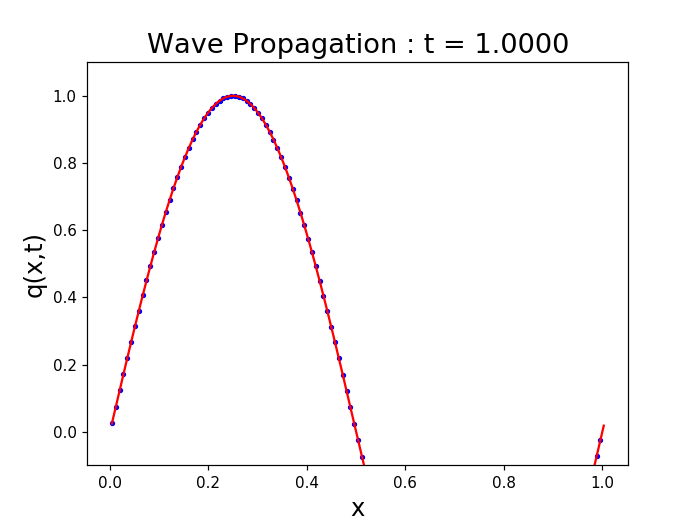

In [8]:
fig = figure(1)
clf()

q0 = Q[:,0]
hdl, = plot(xc,q0,'b.',markersize=5)

xfe = linspace(ax,bx,1000)
xfc = xfe[:-1] + dx/2
hdl_exact, = plot(xfc,qinit(xfc),'r-')

tstr = 'Wave Propagation : t = {:.4f}'
htitle = title(tstr.format(0),fontsize=18)

for i,t in enumerate(tvec):
    q = Q[:,i]
    
    hdl.set_ydata(q)

    qe = qinit(mod(xfc - u*t,1))
    hdl_exact.set_ydata(qe)
    
    xlabel('x',fontsize=16)
    ylabel('q(x,t)',fontsize=16)
    htitle.set_text(tstr.format(t))
    
    ylim([-0.1,1.1])

    fig.canvas.draw()        

## Convergence study

In [17]:
import wpa

Nv = [32,64,128,256,512,1024,2048]
#Nv = [10,  20,  40,  80, 160, 320]
Nv1 = [10, 20,  40,  80, 160]

error = empty((len(Nv),2))
print("{:>8s} {:>12s} {:>8s} {:>12s} {:>8s}".format('N','error(1)','rate(1)','error(2)','rate(2)'))
print("{:s}".format('-'*52))
for i,N in enumerate(Nv):

    # Compute maximum wave speed over the mesh
    umax = u    # Constant for scalar advection
    
    # Estimate time step
    dx = (bx-ax)/N
    dt_est = cfl*dx/umax;
    M = int(floor(Tfinal/dt_est) + 1)
    dt = Tfinal/M
        
    # First order solution
    Q1,xc,tvec = wpa.claw1(ax,bx, N,  Tfinal, M, \
                         rp=rp1_advection, \
                         qinit=qinit, \
                         bc=bc_periodic, \
                         limiter_choice=None,
                         second_order=False)

    # Second order solution
    Q2,xc,tvec = wpa.claw1(ax,bx, N,  Tfinal, M, \
                         rp=rp1_advection, \
                         qinit=qinit, \
                         bc=bc_periodic, \
                         limiter_choice=None,
                         second_order=True)
    
    qe = qexact(xc,Tfinal)    

    error[i,0] = abs(qe-Q1[:,-1]).max()  # First order error
    error[i,1] = abs(qe-Q2[:,-1]).max()  # Second order error

    rate_str = ['']*2
    if i == 0:
        rs = format("{:>8s}").format('---')
        rate_str = [rs]*2
    else:
        rs1 = log2(error[i-1,0]/error[i,0])  
        rs2 = log2(error[i-1,1]/error[i,1])
        rstr = "{:8.4f}"
        rate_str = [rstr.format(rs1), rstr.format(rs2)]

    print("{:8d} {:12.4e} {:s} {:12.4e} {:s}".format(N,error[i,0],rate_str[0], \
                                                    error[i,1],rate_str[1]))
    

       N     error(1)  rate(1)     error(2)  rate(2)
----------------------------------------------------
      32   1.2648e-01      ---   1.5723e-02      ---
      64   6.2662e-02   1.0132   3.7892e-03   2.0529
     128   3.1112e-02   1.0101   9.2822e-04   2.0293
     256   1.5492e-02   1.0060   2.2960e-04   2.0154
     512   7.7287e-03   1.0032   5.7088e-05   2.0078
    1024   3.8599e-03   1.0017   1.4233e-05   2.0040
    2048   1.9288e-03   1.0008   3.5533e-06   2.0020


<IPython.core.display.Javascript object>


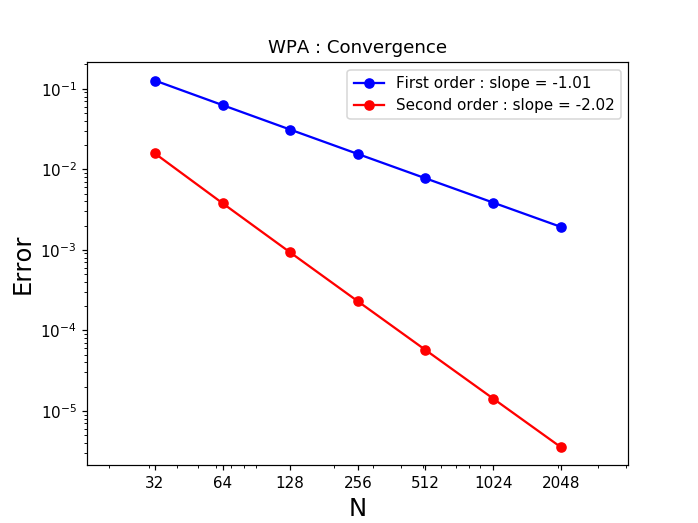

In [18]:
from cg_graphics import set_xticks

figure(2)
clf()

p = polyfit(log(Nv),log(error[:,0]),1)
loglog(Nv,error[:,0],'b.-',markersize=12,label="First order : slope = {:.2f}".format(p[0]))

p = polyfit(log(Nv),log(error[:,1]),1)
loglog(Nv,error[:,1],'r.-',markersize=12,label="Second order : slope = {:.2f}".format(p[0]))

set_xticks(Nv)
xlabel('N',fontsize=16)
ylabel('Error',fontsize=16)
title('WPA : Convergence')
       
legend()

show()

           N     error(1)  rate(1)     error(2)  rate(2)
    ----------------------------------------------------
          32   4.4296e-01      ---   5.1061e-01      ---
          64   4.5622e-01  -0.0426   5.4364e-01  -0.0904
         128   4.6874e-01  -0.0391   5.7036e-01  -0.0692
         256   4.7780e-01  -0.0276   5.9136e-01  -0.0522
         512   4.8427e-01  -0.0194   6.0776e-01  -0.0394
        1024   4.8886e-01  -0.0136   6.2050e-01  -0.0299
        2048   4.9212e-01  -0.0096   6.3041e-01  -0.0229

# Comparison between WPA and CG/DG method

#### considering WPA grid points as CG global gird points for polynomial order 1

          N     error(1)   rate(1)    error(2)   rate(2)
    ----------------------------------------------------
          11   6.3439e-01      ---   5.2653e-01      ---
          21   5.2590e-01   0.2706   3.4722e-01   0.6007
          41   3.8703e-01   0.4423   2.0002e-01   0.7957
          61   3.0883e-01   0.3256   1.1562e-01   0.7908
          81   2.5766e-01   0.2613   7.0051e-02   0.7229
         121   1.9410e-01   0.4087   3.2843e-02   1.0928
         161   1.5591e-01   0.3161   1.8542e-02   0.8248
         
         First order : slope = -0.53
         Second order : slope = -1.24
         
#### considering WPA grid points as CG global gird points for polynomial order 2
         
          N     error(1)  rate(1)     error(2)   rate(2)
    ----------------------------------------------------
          21   5.2590e-01      ---   3.4722e-01      ---
          41   3.8703e-01   0.4423   2.0002e-01   0.7957
          81   2.5766e-01   0.5869   7.0051e-02   1.5137
         121   1.9410e-01   0.4087   3.2843e-02   1.0928
         161   1.5591e-01   0.3161   1.8542e-02   0.8248
         241   1.1202e-01   0.4770   8.2634e-03   1.1660
         321   8.7461e-02   0.3571   4.6434e-03   0.8315
         
         First order : slope = -0.66
         Second order : slope = -1.63
         
#### CG method for polynomial order 1 and 2

        Np(1)     error(1)  rate(1)     Np(2)     error(2)  rate(2)
     --------------------------------------------------------------
          11   7.9875e-03      ---       21   2.6652e-02      ---
          21   2.6578e-03   1.5875       41   8.2410e-03   1.6933
          41   1.2204e-03   1.1229       81   3.3732e-03   1.2887
          61   7.9893e-04   0.6112      121   1.9068e-03   0.8229
          81   5.7832e-04   0.4662      161   1.1725e-03   0.7015
         121   3.3902e-04   0.7705      241   5.5653e-04   1.0751
         161   2.1431e-04   0.6617      321   3.2097e-04   0.7940         
         
        Slopes:
    
        N = 1, slope = -1.251116
        N = 2, slope = -1.551885

#### DG method for polynomial order 1 and 2

     N(1)     error(1)  rate(1)     N(2)     error(2)  rate(2)
    -----------------------------------------------------------------
      11   4.7372e-01      ---       21   4.0907e-01      ---
      21   2.9840e-01   0.6668       41   1.3742e-01   1.5738
      41   1.2866e-01   1.2137       81   1.2019e-02   3.5152
      61   8.0170e-02   0.6824      121   3.0243e-03   1.9906
      81   5.8868e-02   0.4456      161   1.1865e-03   1.3499
     121   3.8693e-02   0.6054      241   3.5785e-04   1.7293
     161   2.8881e-02   0.4220      321   7.5747e-05   2.2401


        
      N     error(1)  rate(1)     error(2)  rate(2)
    ----------------------------------------------------
      32   4.1592e-01      ---   2.5362e-01      ---
      64   2.9751e-01   0.4834   1.0517e-01   1.2699
     128   1.8634e-01   0.6750   2.9539e-02   1.8321
     256   1.0662e-01   0.8054   7.3400e-03   2.0088
     512   5.7510e-02   0.8906   1.8198e-03   2.0120
    1024   2.9946e-02   0.9415   4.5344e-04   2.0048
    2048   1.5291e-02   0.9696   1.1318e-04   2.0023



In [19]:
import pandas as pd
data_cg = pd.read_fwf('cg.txt', sep = "  " ,header = [0])
data_dg = pd.read_fwf('dg.txt', sep = "  " ,header = [0])

<IPython.core.display.Javascript object>


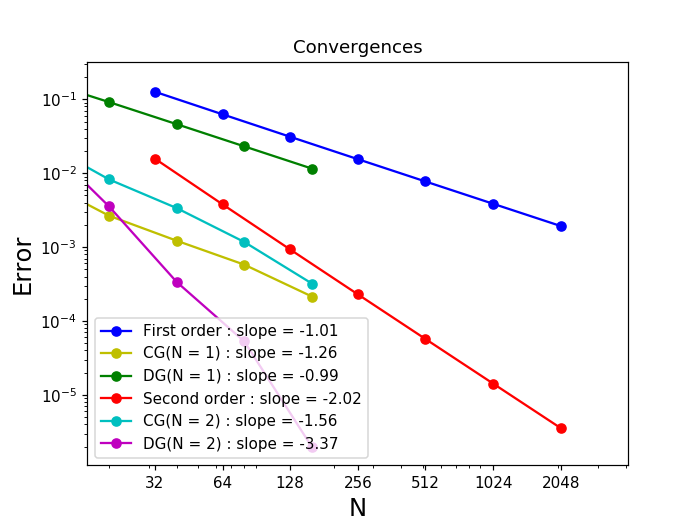

In [21]:
from cg_graphics import set_xticks

figure(3)
clf()

p = polyfit(log(Nv),log(error[:,0]),1)
p_cg = polyfit(log(Nv1),log(array(data_cg.loc[:,"N(1)"])),1)
p_dg = polyfit(log(Nv1),log(array(data_dg.loc[:,"N(1)"])),1)
loglog(Nv,error[:,0],'b.-',markersize=12,label="First order : slope = {:.2f}".format(p[0]))
loglog(Nv1,data_cg.loc[:,"N(1)"],'y.-',markersize=12,label="CG(N = 1) : slope = {:.2f}".format(p_cg[0]))
loglog(Nv1,data_dg.loc[:,"N(1)"],'g.-',markersize=12,label="DG(N = 1) : slope = {:.2f}".format(p_dg[0]))

p = polyfit(log(Nv),log(error[:,1]),1)
p_cg = polyfit(log(Nv1),log(array(data_cg.loc[:,"N(2)"])),1)
p_dg = polyfit(log(Nv1),log(array(data_dg.loc[:,"N(2)"])),1)
loglog(Nv,error[:,1],'r.-',markersize=12,label="Second order : slope = {:.2f}".format(p[0]))
loglog(Nv1,data_cg.loc[:,"N(2)"],'c.-',markersize=12,label="CG(N = 2) : slope = {:.2f}".format(p_cg[0]))
loglog(Nv1,data_dg.loc[:,"N(2)"],'m.-',markersize=12,label="DG(N = 2) : slope = {:.2f}".format(p_dg[0]))

set_xticks(Nv)
xlabel('N',fontsize=16)
ylabel('Error',fontsize=16)
title('Convergences')
       
legend()

show()